# import all datasets

In [34]:
import numpy as np
import pandas as pd
import itertools as it
import statsmodels.api as sm
import statsmodels.formula.api as smf

from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

import scipy.stats as stsats
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn import linear_model
from sklearn import preprocessing
import GRIN_analysis_tools as ga
import warnings
%matplotlib inline
warnings.filterwarnings('ignore')


In [35]:
export_path = '/Volumes/lab-kohlj/home/shared/projects/pregnancy_2021/Figure_4/linked_figure_4/'

# single neuron level analysis: effect of selectivity on retrieval tuning

## spontaneous activities and pup sniff tuning

In [36]:
t_value  = pd.read_csv('generated_dataset/tuning_results.csv').iloc[:,1:]
t_value = t_value[(t_value.Behaviour == 'pup sniff')& (t_value.State.isin(['virgin', 'PD18', 'PD50']))]
baseline = pd.read_csv('generated_dataset/baseline.csv').iloc[:,1:]
props = pd.merge(baseline, t_value, on= ['IDs', 'State', 'Cell_index'])

### getting the slope on each animal base

In [37]:
model = linear_model.LinearRegression()
IDs = ['JKAA40.3e', 'JKAA40.4i', 'JKAA40.4h','JKAA40.5d', 'JKAA44.2i', 'JKAA48.3d']
states = ['virgin', 'PD18', 'PD50']
slopes = pd.DataFrame()
for state in states:
    for ID in IDs:
       
        df = props[(props.IDs == ID) & (props.State == state)]
        
        if df.empty:
            continue

        model.fit(np.array(df.norm_baseline_mean).reshape(-1,1), np.array(df.t_norm_all).reshape(-1,1))
        slope = model.coef_[0][0]
        
        sl = {}
        sl['IDs'] = ID
        sl['State'] = state
        sl['slope'] = slope
        sl = pd.DataFrame(sl, index = [0])
        slopes = pd.concat([slopes, sl])

print(stats.ttest_ind(slopes[slopes.State == 'virgin'].slope, slopes[slopes.State == 'PD18'].slope))

TtestResult(statistic=1.9704687718853302, pvalue=0.08428251446406296, df=8.0)


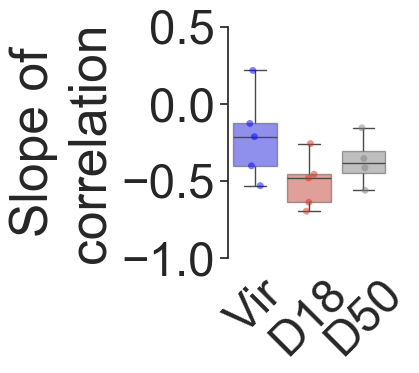

In [38]:
colors_all = ['#0000ff', '#d7301f', '#808080']

plt.subplots(figsize = [2.1,3])
sns.set(font_scale=2.5) 
sns.set_style("ticks")
ax = sns.boxplot(x = 'State', y = 'slope', data = slopes, palette = colors_all, boxprops=dict(alpha=.5), zorder=0)
ax = sns.stripplot(x = 'State', y = 'slope', data = slopes, palette = colors_all, alpha = 0.5) # , dodge=True, alpha = 0.5, palette=colors_all, dodge = True, palette = ['#0000ff', '#d7301f', '#808080'], alpha = 0.5
ax.set_xticklabels( ('Vir', 'D18', 'D50'), rotation=45)
ax.set_xlabel('')
ax.set_ylabel('Slope of\ncorrelation', labelpad=5)
plt.ylim(-1,0.5)
ax.yaxis.set_major_locator(plt.MaxNLocator(3))
sns.despine(bottom=True)
ax.tick_params(bottom=False)
# plt.savefig(export_path + 'slope' + '_corr.pdf', dpi = 300, bbox_inches='tight')

### stats for all neurons

In [39]:
state = 'virgin'
state_df = props[props.State == state]
model = smf.ols("norm_baseline_mean ~t_norm_all", data = state_df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     norm_baseline_mean   R-squared:                       0.047
Model:                            OLS   Adj. R-squared:                  0.041
Method:                 Least Squares   F-statistic:                     7.818
Date:                Sun, 01 Oct 2023   Prob (F-statistic):            0.00581
Time:                        22:48:53   Log-Likelihood:                -19.431
No. Observations:                 162   AIC:                             42.86
Df Residuals:                     160   BIC:                             49.04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.3308      0.024     13.932      0.000       0.284       0.378
t_norm_all    -0.1756      0.063     -2.796      0.006      -0.300      -0.052
==============================================================================
Omnibus:                       16.732   Durbin-Watson:                   1.356
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               18.545
Skew:                           0.796   Prob(JB):                     9.40e-05
Kurtosis:                       2.537   Cond. No.                         2.99
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<Figure size 175x175 with 0 Axes>

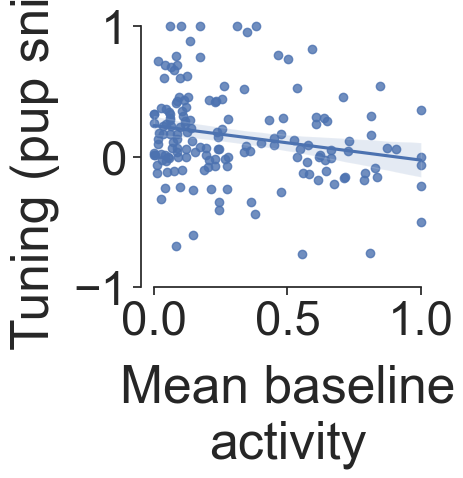

In [40]:
plt.figure(figsize=(1.75,1.75))
sns.set(font_scale=3.1) 
sns.set_style("ticks")
sns.lmplot(x="norm_baseline_mean", y='t_norm_all', data= state_df) #hue = 'State'
plt.ylim([-1,1.1])
plt.xticks([0,0.5,1.0])
plt.xlabel('Mean baseline\nactivity', labelpad=15)
plt.ylabel('Tuning (pup sniff)', labelpad=10)
sns.despine(trim=True)

# plt.savefig(f'output_figures/baseline_tvalue_corr_{state}.pdf',dpi = 300, bbox_inches='tight')
# plt.savefig(export_path + state + '_baseline_tvalue_corr.pdf', dpi = 300, bbox_inches='tight')

# parameter correlation analysis

## dataset preparation

In [41]:
dis = pd.read_csv('generated_dataset/discriminability.csv')
proportion = pd.read_csv('generated_dataset/proportions.csv').iloc[:,1:]
proportion = proportion[proportion.Behaviour == 'retrieval to nest']
path = 'dataset/'
convolve = 'non_convolved'

In [42]:
IDs = ['JKAA40.3e','JKAA40.4i', 'JKAA40.4h','JKAA40.5d', 'JKAA44.2i', 'JKAA48.3d']
states = ['virgin', 'PD18', 'PD50']
bdfs = pd.DataFrame(columns = ['IDs', 'State', 'Behaviour', 'Duration', 'Latency'])

fr = 20

for ID in IDs:
    
    for state in states:
        # if ID == 'JKAA40.5d':
        #     break
            
        storage = {}
       
        try:
            df = ga.load_inscopix(path + f'{ID}/{convolve}/{ID}_registered_{state}'+'.csv', normalisation= 'fixed interval')
            _, binary, events = ga.preprocess_behaviour(path + f'{ID}/{ID}_behav_{state}_post.csv', df.shape[1])
            print(f'processing : {ID}_{state}')
        except FileNotFoundError:
            continue
        num = len(binary.columns.unique())
        
        storage['IDs'] = [ID] * num
        storage['State'] = [state] * num
        storage['Behaviour'] = binary.columns.unique().tolist()
        storage = pd.DataFrame(storage)
        
        try:
            bdf = pd.read_csv(path + f'{ID}/{ID}_behav_{state}_post.csv')
            sequence = bdf[bdf.Status == 'START'].Behavior.tolist()
            T = pd.crosstab(
            pd.Series(sequence[:-1], name='state1'),
            pd.Series(sequence[1:], name='state2'),
            normalize=0)

            storage['transition'] = T.loc['pup sniff', 'retrieval to nest']
        except KeyError:
            continue
        
        for behaviour in binary.columns.unique():
            try:
                total = np.where(binary['end trial'].diff() > 0)[0][0] -np.where(binary['pup intro'].diff() > 0)[0][0]
                storage.loc[storage['Behaviour'] == behaviour, 'Duration'] = binary[behaviour].sum() 
                storage.loc[storage['Behaviour'] == behaviour, 'Latency'] = (np.where(binary[behaviour].diff() > 0)[0][0] - np.where(binary['pup intro'].diff() > 0)[0][0]) /total
                

            except KeyError:
                continue
            bdfs = pd.concat([bdfs,storage])

processing : JKAA40.3e_virgin
processing : JKAA40.3e_PD18
processing : JKAA40.3e_PD50
processing : JKAA40.4i_virgin
processing : JKAA40.4i_PD18
processing : JKAA40.4i_PD50
processing : JKAA40.4h_virgin
processing : JKAA40.4h_PD18
processing : JKAA40.4h_PD50
processing : JKAA40.5d_virgin
processing : JKAA40.5d_PD18
processing : JKAA44.2i_virgin
processing : JKAA44.2i_PD18
processing : JKAA44.2i_PD50
processing : JKAA48.3d_virgin
processing : JKAA48.3d_PD18


In [43]:
par_behavs = ['nest time', 'nest building']
lat_behavs = ['retrieval to nest']

bdf_dis = pd.merge(bdfs,slopes, on = ['IDs', 'State'])

for ID in IDs:
    for state in states:
        sub = bdf_dis[(bdf_dis.IDs == ID) & (bdf_dis.State == state)] 
        compo = sub[sub.Behaviour.isin(par_behavs)].Duration.unique()
        compo = compo[~np.isnan(compo)].sum()
        
        if compo == 0:
            continue
        
        lat = sub[sub.Behaviour.isin(lat_behavs)].Latency.unique()
        # lat = lat[~np.isnan(lat)].min()
        lat = (1/lat[~np.isnan(lat)]).min()
        print(ID, state,np.array(lat) )
       
        # bdf_dis.loc[(bdf_dis.IDs == ID)&(bdf_dis.State == state),'composite_behav'] = np.array(compo) 
        bdf_dis.loc[(bdf_dis.IDs == ID)&(bdf_dis.State == state),'composite_behav'] = np.array(lat) 
        # bdf_dis.loc[(bdf_dis.IDs == ID)&(bdf_dis.State == state),'composite_behav'] = sub[sub.Behaviour == 'retrieval to nest'].Latency

bdf_dis = bdf_dis.dropna()
# corr = bdf_dis[(bdf_dis['Behaviour'] == 'retrieval to nest') &
#              (bdf_dis['behaviour_combo'] == bdf_dis['behaviour_combo'].tolist()[0])]
corr = bdf_dis.drop_duplicates()

JKAA40.3e virgin 2.2698059822150363
JKAA40.3e PD18 12.538461538461538
JKAA40.3e PD50 3.023159078133783
JKAA40.4i virgin 33.244514106583075
JKAA40.4i PD50 90.99086757990868
JKAA40.4h virgin 5.206825938566553
JKAA40.4h PD18 27.175
JKAA40.4h PD50 222.5757575757576
JKAA40.5d PD18 8.60485651214128
JKAA44.2i virgin 1.4454845814977975
JKAA44.2i PD18 76.41471571906354
JKAA44.2i PD50 1.1605807543256372


In [44]:
number = pd.read_csv('generated_dataset/numbers.csv')
corr = corr.merge(number, on = ['IDs', 'State'])
corr = corr.merge(proportion, on = ['IDs', 'State'])
corr = corr.merge(dis[dis.behaviour_combo == "('pup sniff', 'intruder contact')"], on = ['IDs', 'State'])

## modularity correlation

In [26]:
model = smf.ols('Rand_index ~ modularity ', data=corr).fit()
model.summary()

PatsyError: Error evaluating factor: NameError: name 'Rand_index' is not defined
    Rand_index ~ modularity
    ^^^^^^^^^^

In [ ]:
sns.lmplot(x='modularity', y='Rand_index', data=corr,truncate = False)
sns.despine()
plt.savefig('output_figures/modularity_tuning.png', dpi = 300, bbox_inches='tight')

KeyError: "['modularity'] not in index"

## tuning index and discriminability

In [45]:
corr['tuned'] = corr['Increasing'] + corr['Decreasing']

In [46]:
model = smf.ols('Increasing ~ Rand_index', data=corr).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Increasing   R-squared:                       0.420
Model:                            OLS   Adj. R-squared:                  0.416
Method:                 Least Squares   F-statistic:                     109.1
Date:                Sun, 01 Oct 2023   Prob (F-statistic):           1.45e-19
Time:                        22:49:38   Log-Likelihood:                 73.401
No. Observations:                 153   AIC:                            -142.8
Df Residuals:                     151   BIC:                            -136.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.2943      0.095     13.631      0.000       1.107       1.482
Rand_index    -1.1618      0.111    -10.447      0.000      -1.382      -0.942
==============================================================================
Omnibus:                      777.987   Durbin-Watson:                   0.087
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               17.602
Skew:                           0.373   Prob(JB):                     0.000151
Kurtosis:                       1.515   Cond. No.                         15.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

(0.0, 1.0)

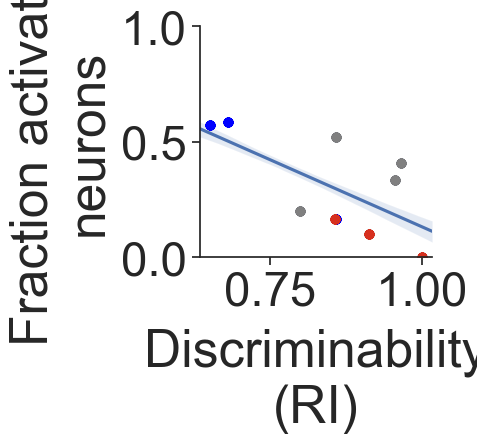

In [48]:
plt.figure(figsize=(3,3))
sns.set(font_scale=3.1) 
sns.set_style("ticks")
sns.regplot(x='Rand_index',y = 'Increasing',  data=corr, truncate = False)

colors = ['#0000ff', '#d7301f', 'gray']
for i, state in enumerate(['virgin', 'PD18', 'PD50']):
    df = corr[corr.State == state]
    plt.scatter(df.Rand_index, df.Increasing, color = colors[i])
sns.despine()
plt.xticks()
plt.yticks()
plt.xlabel('Discriminability\n(RI)', labelpad=10)
plt.ylabel('Fraction activated\nneurons', labelpad=5)
plt.ylim(0,1)
# ax.yaxis.set_major_locator(plt.MaxNLocator(4))
# plt.savefig('output_figures/rand_tuning.pdf', dpi = 300, bbox_inches='tight')
# plt.savefig(export_path + 'ra÷nd_tuning.pdf', dpi = 300, bbox_inches='tight', transparent=True)